In [1]:
import geopandas as gpd
from osmnx.distance import nearest_nodes
import osmnx as ox
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

WALK_RADIUS = 1609.34
SECTORS = ['comercio', 'servicios', 'salud', 'educacion']

In [2]:
def calculate_batch_walking_times(G, sources, targets):
  walking_speed_m_per_s = 1.4  # Average walking speed in meters per second
  # Calculate shortest path lengths in meters for all source-target pairs
  lengths = dict(nx.all_pairs_dijkstra_path_length(G, cutoff=900, weight='length'))  # 900 seconds = 15 minutes

  # Filter lengths for our sources and targets, convert to time in minutes
  walking_times = {}
  for source in sources:
    for target in targets:
      if source in lengths and target in lengths[source]:
        # Convert length to walking time (in minutes)
        walking_times[(source, target)] = lengths[source][target] / walking_speed_m_per_s / 60

  return walking_times

In [3]:
gdf_lots = gpd.read_file("../data/processed/predios.geojson", crs="EPSG:4326")
gdf_denue = gpd.read_file("../data/processed/denue.geojson", crs="EPSG:4326")
gdf_denue = gdf_denue.loc[gdf_denue['sector'].isin(SECTORS)]

In [4]:
# Generate the pedestrian network graph around the combined area of interest
unified_area = gdf_lots.unary_union.convex_hull | gdf_denue.unary_union.convex_hull
G = ox.graph_from_polygon(unified_area, network_type='walk')

In [6]:
# Find nearest network nodes to lot centroids and amenities
gdf_lots['nearest_node'] = ox.distance.nearest_nodes(G, gdf_lots.geometry.centroid.x, gdf_lots.geometry.centroid.y)
gdf_denue['nearest_node'] = ox.distance.nearest_nodes(G, gdf_denue.geometry.x, gdf_denue.geometry.y)

/var/folders/yd/71__64q967d7gl413c68q10m0000gp/T/ipykernel_81027/1259390830.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_lots['nearest_node'] = ox.distance.nearest_nodes(G, gdf_lots.geometry.centroid.x, gdf_lots.geometry.centroid.y)


In [7]:
# Get unique source and target nodes for batch processing
source_nodes = gdf_lots['nearest_node'].unique()
target_nodes = gdf_denue['nearest_node'].unique()

In [8]:
len(source_nodes), len(target_nodes), len(gdf_lots), len(gdf_denue)

(747, 2589, 5527, 6841)

In [11]:
import pandas as pd

# Calculate batch walking times between sources and targets
walking_times = calculate_batch_walking_times(G, source_nodes, target_nodes)

# Convert walking_times to DataFrame for easier processing
times_df = pd.DataFrame([(s, t, time) for (s, t), time in walking_times.items()],
                        columns=['source', 'target', 'time'])

In [27]:
decay_rate = 0.05

# Merge walking times back to amenities based on 'nearest_node'
gdf_denue_times = pd.merge(gdf_denue, times_df, left_on='nearest_node', right_on='target')
# Filter amenities within walking radius (15 minutes)
gdf_denue_within_radius = gdf_denue_times[gdf_denue_times['time'] <= WALK_RADIUS / 60]
# Calculate proximity scores
gdf_denue_within_radius['proximity_score'] = np.exp(-decay_rate * gdf_denue_within_radius['time'])
gdf_denue_within_radius

,sector,num_workers,nom_estab,fecha_alta,codigo_act,geometry,nearest_node,source,target,time,proximity_score
0,comercio,2.5,ABARROTES CHAN,2019-11,431110,POINT (-100.27697 25.65747),4968913494,7239649503,4968913494,7.034476,0.703474
1,comercio,2.5,ABARROTES CHAN,2019-11,431110,POINT (-100.27697 25.65747),4968913494,7979601801,4968913494,9.058714,0.635759
2,comercio,2.5,ABARROTES CHAN,2019-11,431110,POINT (-100.27697 25.65747),4968913494,4968913716,4968913494,8.844595,0.642602
3,comercio,2.5,ABARROTES CHAN,2019-11,431110,POINT (-100.27697 25.65747),4968913494,2485209317,4968913494,8.917143,0.640275
4,comercio,2.5,ABARROTES CHAN,2019-11,431110,POINT (-100.27697 25.65747),4968913494,4968896882,4968913494,7.464405,0.688514
...,...,...,...,...,...,...,...,...,...,...,...
264487,servicios,2.5,VULCANIZADORA SANCHEZ,2010-07,811191,POINT (-100.29839 25.65945),6990870395,7267438917,6990870395,4.089774,0.815064
264488,servicios,2.5,VULCANIZADORA SANCHEZ,2010-07,811191,POINT (-100.29839 25.65945),6990870395,1433046436,6990870395,8.768655,0.645047
264489,servicios,2.5,VULCANIZADORA SANCHEZ,2010-07,811191,POINT (-100.29839 25.65945),6990870395,2378528850,6990870395,10.240214,0.599289
264490,servicios,2.5,VULCANIZADORA SANCHEZ,2010-07,811191,POINT (-100.29839 25.65945),6990870395,7511829014,6990870395,10.262429,0.598624


In [54]:
test

,CLAVE_LOTE,proximity_score,comercio,servicios,salud,educacion,geometry,comercio_weight,servicios_weight,salud_weight,educacion_weight,weighted_score
0,7015,110.595031,105,51,9,5,"MULTIPOLYGON (((-100.27983 25.65692, -100.2801...",26.25,12.75,4.5,2.5,25.8
1,7015001001,214.625531,166,83,30,10,"POLYGON ((-100.27431 25.65138, -100.27495 25.6...",41.50,20.75,15.0,5.0,48.2
2,7015001003,134.672668,119,55,18,5,"POLYGON ((-100.27391 25.65330, -100.27366 25.6...",29.75,13.75,9.0,2.5,31.6
3,7015001004,135.455106,117,55,17,3,"POLYGON ((-100.27267 25.65342, -100.27243 25.6...",29.25,13.75,8.5,1.5,30.4
4,7015001005,179.780654,144,74,26,4,"POLYGON ((-100.27532 25.65367, -100.27571 25.6...",36.00,18.50,13.0,2.0,40.8
...,...,...,...,...,...,...,...,...,...,...,...,...
5522,7043189009,186.611593,158,64,29,29,"POLYGON ((-100.28349 25.64627, -100.28349 25.6...",39.50,16.00,14.5,14.5,48.9
5523,7043189010,186.611593,158,64,29,29,"POLYGON ((-100.28333 25.64614, -100.28333 25.6...",39.50,16.00,14.5,14.5,48.9
5524,7043189011,209.182896,176,74,29,35,"POLYGON ((-100.28353 25.64616, -100.28354 25.6...",44.00,18.50,14.5,17.5,54.5
5525,7043189012,209.182896,176,74,29,35,"POLYGON ((-100.28349 25.64635, -100.28352 25.6...",44.00,18.50,14.5,17.5,54.5


<Axes: >

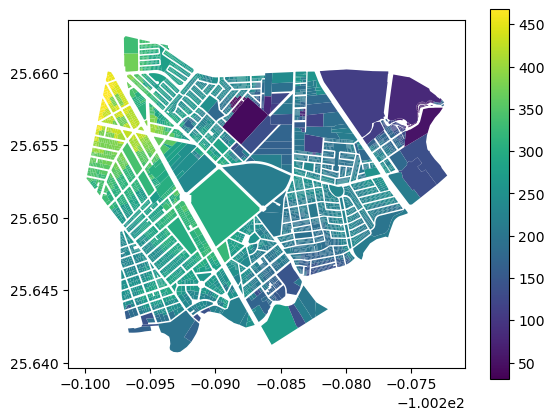

In [33]:
# now merge with the lots
test = pd.merge(gdf_lots, gdf_denue_within_radius.drop(columns=["nearest_node", "geometry"]), left_on='nearest_node', right_on='source', how='left')
test = test.groupby('CLAVE_LOTE').agg({
  'proximity_score': 'sum',
  'sector': lambda x: dict(x.value_counts())
}).reset_index()
for sector in SECTORS:
  test[sector] = test['sector'].apply(lambda x: x.get(sector, 0))
test = gpd.GeoDataFrame(test.drop(columns=["sector"]), geometry=gdf_lots.geometry, crs="EPSG:4326")
test.plot(column='proximity_score', legend=True)

<Axes: >

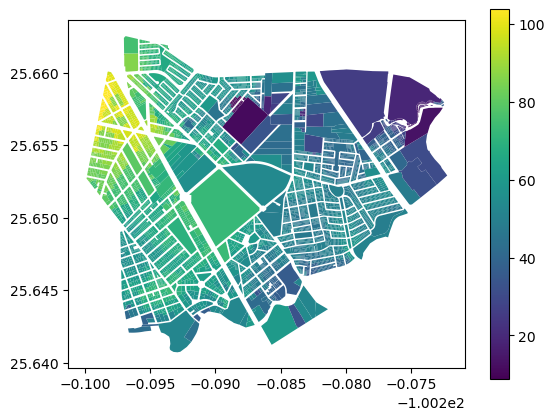

In [53]:
sector_weight_mapping = {
    'comercio': 0.1,
    'servicios': 0.2,
    'salud': 0.4,
    'educacion': 0.3
}
test['weighted_score'] = 0
for sector in SECTORS:
  test['weighted_score'] += test[sector] * sector_weight_mapping[sector]
test.plot(column='weighted_score', legend=True)